In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

AxesLabel, TickLabel = [20, 20]
plt.rcParams.update({
    'font.size' : TickLabel,                   # Set font size to 11pt
    'axes.labelsize': AxesLabel,               # -> axis labels
    'legend.fontsize': AxesLabel,              # -> legends
    'xtick.labelsize': TickLabel,              # -> x-axis tick labels
    'ytick.labelsize': TickLabel,              # -> y-axis tick labels
})

## Essential functions!

Here we define functions to compute the contact angle given the volume and width of the droplet sitting on a substrate. 

In [2]:
# this function solve_cubic is to calculate the roots of a 3rd order polynomial.  
def solve_cubic(b, c):
    # roots of the equation x^3 + b*x + c = 0
    p1 = ((2/3)**(1/3))*b
    p2 = (-9*c + (3**(1/2))*(4*(b**3) + 27*(c**2))**(1/2))**(1/3)
    q2 = (2**(1/3))*(3**(2/3))

    p = p1/p2
    q = p2/q2

    return -p+q

# the function findTheta finds the height, radius of curvature, and the contact angle of a spherical cap given its volume and width.
# Note that the contact angle is same as the polar angle of the spherical cap.
def findTheta(V, w):
  # given width of the spherical cap and its volume, find its height by solving the equation: V = 1/6 pi h (3(w/2)^2 + h^2) for h. 
  # solve for h using roots of a 3rd order polynomial
  # V = 1/6 pi h (3(w/2)^2 + h^2)
  # h^3 + 3(w/2)^2 h - 6V/pi = 0

  h = solve_cubic(3*((w/2)**2), -6*V/np.pi)    
  # now find the radius of the base sphere using w. 
  # R - h = Rcos(theta)
  # R = (w/2)/sin(theta)
  # (R-h)^2 + (w/2)^2 = R^2
  # R^2 - 2Rh + h^2 + (w/2)^2 = R^2
  # h^2 - 2Rh + (w/2)^2 = 0
  R = (h**2 + (w/2)**2)/(2*h)

  # now find theta using R = (w/2)/sin(theta)

  theta = np.arcsin(w/(2*R))

  return h, R, theta

## Model from the paper

### some parameters and assumptions
Initial volume is $V_0$ constructed using a base sphere of unit radius and polar angle (also the drop contact angle) of the spherical cap as THETA0test. The volume decays linearly due to volume flow of (say) $q = 0.18$. $\beta$ is 1. $\theta_{eq}$ is 75 degrees. $\gamma_{LG}$ is 1. 

In [3]:
THETA0test = 85/180*np.pi # initial contact angle
w0 = 2*np.sin(THETA0test) # width of the spherical cap
V0 = (1/3)*np.pi*(2+np.cos(THETA0test))*(1-np.cos(THETA0test))**2
ThetaEQ = 75*np.pi/180 # equilibrium contact angle
h0, R0, theta0  = findTheta(V0, w0)
print("Error in initially assumed angle = %3.2e" % abs(theta0-THETA0test))

print("Initial drop characteristics: Vol = %3.2f, h = %3.2f, R = %3.2f, theta (degrees) = %3.2f, w = %3.2f\n" % (V0, h0, R0, theta0/np.pi*180, w0))

q = 0.18 # volume flow rate
beta, gammaLG = 1, 1 # fitting parameter of the present model and the liquid-gas surface tension coefficient
t = np.linspace(0, 10, 10000) # time
DELTAt = t[1]-t[0]

V = V0 - q*t # volume of the spherical cap as a function of time

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# ax.plot(t, V, 'k-', lw=2, label=r'$V(t)$')
# ax.set_xlabel('$t$')
# ax.set_ylabel('$V$')
# ax.legend(loc='best', fontsize=30)
# ax.set_xlim(0, 10)
# ax.set_ylim(0, 1.1*V0)

Error in initially assumed angle = 2.22e-15
Initial drop characteristics: Vol = 1.82, h = 0.91, R = 1.00, theta (degrees) = 85.00, w = 1.99



### Equation of motion (this paper)

$$ v = \frac{dw}{dt} =
	\begin{cases}
		\quad\,\,0 &\forall\quad\theta > \theta_{eq}\\
		\,\,\,-\frac{2\gamma_{LG}}{\beta}\left(\cos\theta - \cos\theta_{eq}\right) &\forall\quad\theta < \theta_{eq}
	\end{cases}$$

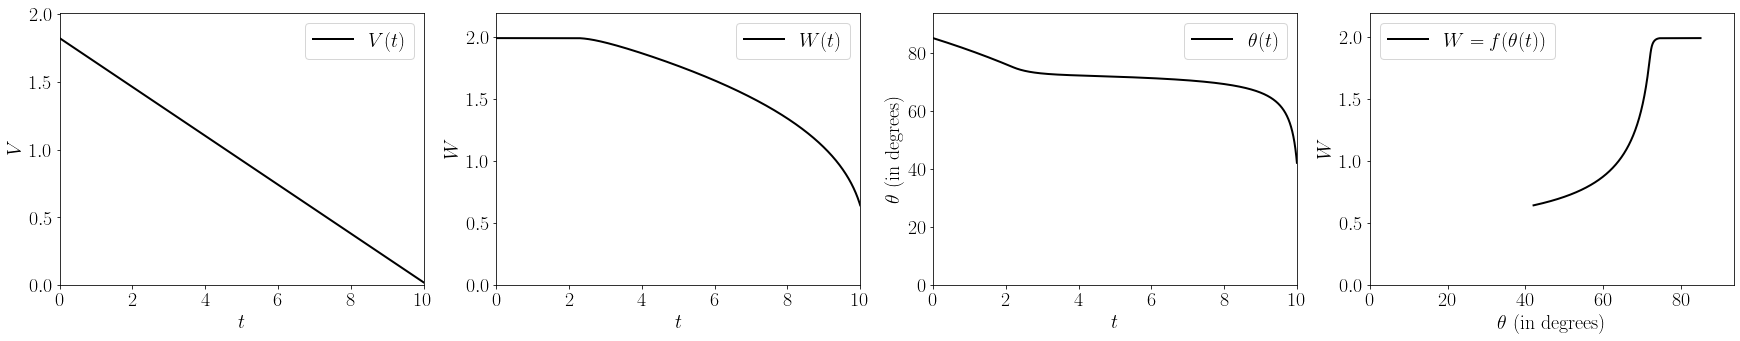

In [4]:
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -2*(gammaLG/beta)*(np.cos(theta)-np.cos(ThetaEQ))
    w.append(w[-1] + Force*DELTAt)

THETA = np.array(thetaTemp)    
W = np.array(w)

# now, we make some plots!
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

ax1.plot(t, V, 'k-', lw=2, label=r'$V(t)$')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$V$')
ax1.legend(loc='best', fontsize=AxesLabel)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 1.1*V.max())

ax2.plot(t, W, 'k-', lw=2, label=r'$W(t)$')
ax2.set_xlabel('$t$')
ax2.set_ylabel('$W$')
ax2.legend(loc='best', fontsize=AxesLabel)
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 1.1*W.max())

ax3.plot(t, THETA/np.pi*180, 'k-', lw=2, label=r'$\theta(t)$')
ax3.set_xlabel('$t$')
ax3.set_ylabel('$\\theta$ (in degrees)')
ax3.legend(loc='best', fontsize=AxesLabel)
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 1.1*(THETA.max()/np.pi*180))

ax4.plot(THETA/np.pi*180, W, 'k-', lw=2, label=r'$W = f(\theta(t))$')
ax4.set_ylabel('$W$')
ax4.set_xlabel('$\\theta$ (in degrees)')
ax4.legend(loc='best', fontsize=AxesLabel)
ax4.set_ylim(0, 1.1*W.max())
ax4.set_xlim(0, 1.1*(THETA.max()/np.pi*180))

plt.show()

Out of curiosity, let us try what happens if we replace by $\cos\theta$ by the first two terms of the Taylor expansion.

$$ \cos\theta = 1 - \frac{\theta^2}{2} + \frac{\theta^4}{24} + \cdots$$

Equation of motion is then: 

$$ v = \frac{dw}{dt} =
	\begin{cases}
		\quad\,\,0 &\forall\quad\theta > \theta_{eq}\\
		\,\,\,-\frac{\gamma_{LG}}{\beta}\left(\theta_{eq}^2 - \theta^2\right) &\forall\quad\theta < \theta_{eq}
	\end{cases}$$

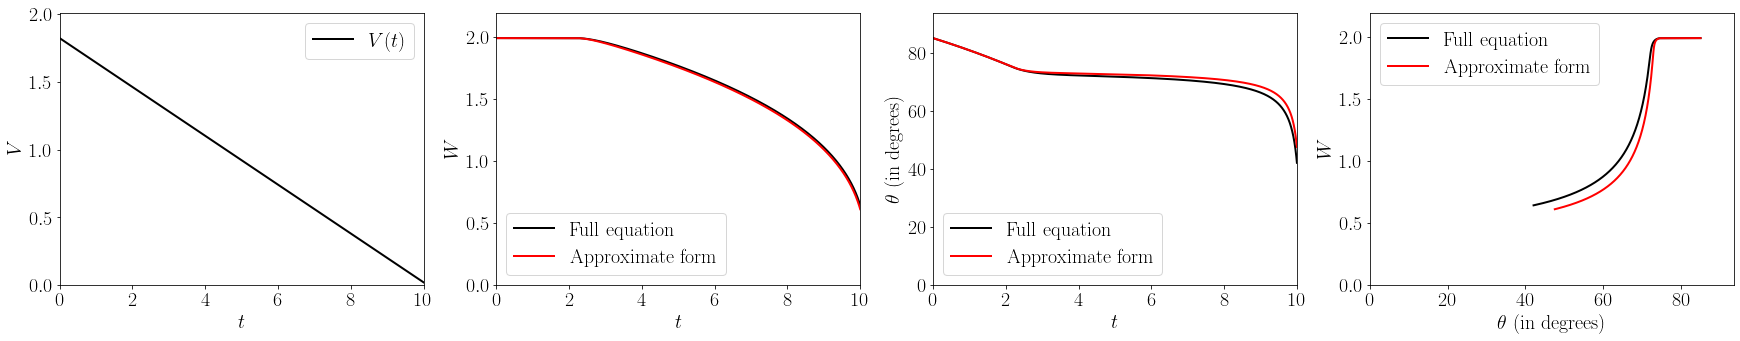

In [5]:
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(gammaLG/beta)*(ThetaEQ**2-theta**2)
    w.append(w[-1] + Force*DELTAt)

THETA2 = np.array(thetaTemp)    
W2 = np.array(w)

# now, we make some plots!
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

ax1.plot(t, V, 'k-', lw=2, label=r'$V(t)$')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$V$')
ax1.legend(loc='best', fontsize=TickLabel)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 1.1*V.max())

ax2.plot(t, W, 'k-', lw=2, label='Full equation')
ax2.plot(t, W2, 'r-', lw=2, label='Approximate form')
ax2.set_xlabel('$t$')
ax2.set_ylabel('$W$')
ax2.legend(loc='best', fontsize=TickLabel)
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 1.1*W.max())

ax3.plot(t, THETA/np.pi*180, 'k-', lw=2, label='Full equation')
ax3.plot(t, THETA2/np.pi*180, 'r-', lw=2, label='Approximate form')
ax3.set_xlabel('$t$')
ax3.set_ylabel('$\\theta$ (in degrees)')
ax3.legend(loc='best', fontsize=TickLabel)
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 1.1*(THETA.max()/np.pi*180))

ax4.plot(THETA/np.pi*180, W, 'k-', lw=2,  label='Full equation')
ax4.plot(THETA2/np.pi*180, W2, 'r-', lw=2, label='Approximate form')
ax4.set_ylabel('$W$')
ax4.set_xlabel('$\\theta$ (in degrees)')
ax4.legend(loc='best', fontsize=TickLabel)
ax4.set_ylim(0, 1.1*W.max())
ax4.set_xlim(0, 1.1*(THETA.max()/np.pi*180))

plt.show()

Perhaps, the agreement will be nicer for smaller angles!

In [6]:
THETA0test = 65/180*np.pi # initial contact angle
w0 = 2*np.sin(THETA0test) # width of the spherical cap
V0 = (1/3)*np.pi*(2+np.cos(THETA0test))*(1-np.cos(THETA0test))**2
ThetaEQ = 50*np.pi/180 # equilibrium contact angle
h0, R0, theta0  = findTheta(V0, w0)
print("Error in initially assumed angle = %3.2e" % abs(theta0-THETA0test))

print("Initial drop characteristics: Vol = %3.2f, h = %3.2f, R = %3.2f, theta (degrees) = %3.2f, w = %3.2f\n" % (V0, h0, R0, theta0/np.pi*180, w0))

q = 0.08 # volume flow rate
beta, gammaLG = 1, 1 # fitting parameter of the present model and the liquid-gas surface tension coefficient
t = np.linspace(0, 10, 10000) # time
DELTAt = t[1]-t[0]

V = V0 - q*t # volume of the spherical cap as a function of time

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# ax.plot(t, V, 'k-', lw=2, label=r'$V(t)$')
# ax.set_xlabel('$t$')
# ax.set_ylabel('$V$')
# ax.legend(loc='best', fontsize=30)
# ax.set_xlim(0, 10)
# ax.set_ylim(0, 1.1*V0)

Error in initially assumed angle = 6.66e-16
Initial drop characteristics: Vol = 0.85, h = 0.58, R = 1.00, theta (degrees) = 65.00, w = 1.81



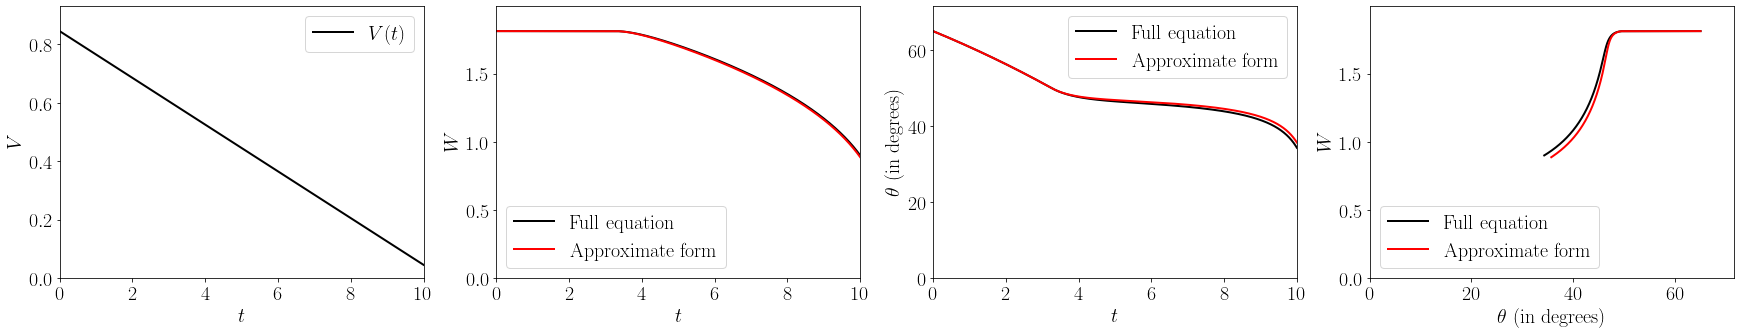

In [7]:
# model without Taylor expansion
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -2*(gammaLG/beta)*(np.cos(theta)-np.cos(ThetaEQ))
    w.append(w[-1] + Force*DELTAt)

THETA = np.array(thetaTemp)    
W = np.array(w)

# model with Taylor expansion
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(gammaLG/beta)*(ThetaEQ**2-theta**2)
    w.append(w[-1] + Force*DELTAt)

THETA2 = np.array(thetaTemp)    
W2 = np.array(w)

# now, we make some plots!
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

ax1.plot(t, V, 'k-', lw=2, label=r'$V(t)$')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$V$')
ax1.legend(loc='best', fontsize=TickLabel)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 1.1*V.max())

ax2.plot(t, W, 'k-', lw=2, label='Full equation')
ax2.plot(t, W2, 'r-', lw=2, label='Approximate form')
ax2.set_xlabel('$t$')
ax2.set_ylabel('$W$')
ax2.legend(loc='best', fontsize=TickLabel)
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 1.1*W.max())

ax3.plot(t, THETA/np.pi*180, 'k-', lw=2, label='Full equation')
ax3.plot(t, THETA2/np.pi*180, 'r-', lw=2, label='Approximate form')
ax3.set_xlabel('$t$')
ax3.set_ylabel('$\\theta$ (in degrees)')
ax3.legend(loc='best', fontsize=TickLabel)
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 1.1*(THETA.max()/np.pi*180))

ax4.plot(THETA/np.pi*180, W, 'k-', lw=2,  label='Full equation')
ax4.plot(THETA2/np.pi*180, W2, 'r-', lw=2, label='Approximate form')
ax4.set_ylabel('$W$')
ax4.set_xlabel('$\\theta$ (in degrees)')
ax4.legend(loc='best', fontsize=TickLabel)
ax4.set_ylim(0, 1.1*W.max())
ax4.set_xlim(0, 1.1*(THETA.max()/np.pi*180))

plt.show()

## Some notes: 

Of course, note that $\beta$ is just a fittin parameter. So, in principle, we could use different values of $\beta$ such that the two results agree. Let us try that.

We can compare the following two cases:

### Case 1 (Full equation):
$$ v = \frac{dw}{dt} =
	\begin{cases}
		\quad\,\,0 &\forall\quad\theta > \theta_{eq}\\
		\,\,\,-\frac{1}{M_1}\left(\cos\theta - \cos\theta_{eq}\right) &\forall\quad\theta < \theta_{eq}
	\end{cases}$$

### Case 2 (Approximate form):
$$ v = \frac{dw}{dt} =
	\begin{cases}
		\quad\,\,0 &\forall\quad\theta > \theta_{eq}\\
		\,\,\,-\frac{1}{M_2}\left(\theta_{eq}^2 - \theta^2\right) &\forall\quad\theta < \theta_{eq}
	\end{cases}$$

Error in initially assumed angle = 6.66e-16
Initial drop characteristics: Vol = 0.85, h = 0.58, R = 1.00, theta (degrees) = 65.00, w = 1.81



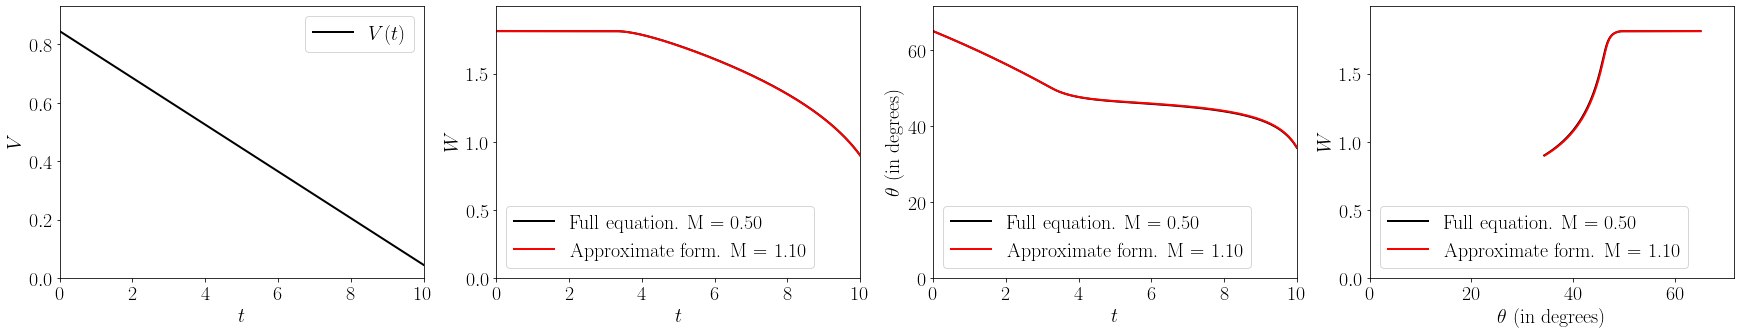

In [8]:
THETA0test = 65/180*np.pi # initial contact angle
w0 = 2*np.sin(THETA0test) # width of the spherical cap
V0 = (1/3)*np.pi*(2+np.cos(THETA0test))*(1-np.cos(THETA0test))**2
ThetaEQ = 50*np.pi/180 # equilibrium contact angle
h0, R0, theta0  = findTheta(V0, w0)
print("Error in initially assumed angle = %3.2e" % abs(theta0-THETA0test))

print("Initial drop characteristics: Vol = %3.2f, h = %3.2f, R = %3.2f, theta (degrees) = %3.2f, w = %3.2f\n" % (V0, h0, R0, theta0/np.pi*180, w0))

q = 0.08 # volume flow rate
t = np.linspace(0, 10, 10000) # time
DELTAt = t[1]-t[0]

V = V0 - q*t # volume of the spherical cap as a function of time

# model without Taylor expansion
M1 = 0.5
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M1)*(np.cos(theta)-np.cos(ThetaEQ))
    w.append(w[-1] + Force*DELTAt)

THETA = np.array(thetaTemp)    
W = np.array(w)

# model with Taylor expansion
M2 = 1.1
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M2)*(ThetaEQ**2-theta**2)
    w.append(w[-1] + Force*DELTAt)

THETA2 = np.array(thetaTemp)    
W2 = np.array(w)

# now, we make some plots!
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

ax1.plot(t, V, 'k-', lw=2, label=r'$V(t)$')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$V$')
ax1.legend(loc='best', fontsize=TickLabel)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 1.1*V.max())

ax2.plot(t, W, 'k-', lw=2, label='Full equation. M = %3.2f' % M1)
ax2.plot(t, W2, 'r-', lw=2, label='Approximate form. M = %3.2f' % M2)
ax2.set_xlabel('$t$')
ax2.set_ylabel('$W$')
ax2.legend(loc='best', fontsize=TickLabel)
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 1.1*W.max())

ax3.plot(t, THETA/np.pi*180, 'k-', lw=2, label='Full equation. M = %3.2f' % M1)
ax3.plot(t, THETA2/np.pi*180, 'r-', lw=2, label='Approximate form. M = %3.2f' % M2)
ax3.set_xlabel('$t$')
ax3.set_ylabel('$\\theta$ (in degrees)')
ax3.legend(loc='best', fontsize=TickLabel)
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 1.1*(THETA.max()/np.pi*180))

ax4.plot(THETA/np.pi*180, W, 'k-', lw=2,  label='Full equation. M = %3.2f' % M1)
ax4.plot(THETA2/np.pi*180, W2, 'r-', lw=2, label='Approximate form. M = %3.2f' % M2)
ax4.set_ylabel('$W$')
ax4.set_xlabel('$\\theta$ (in degrees)')
ax4.legend(loc='best', fontsize=TickLabel)
ax4.set_ylim(0, 1.1*W.max())
ax4.set_xlim(0, 1.1*(THETA.max()/np.pi*180))

plt.show()

# Comparision with Cox-Voinov model


### Case 1 (Full equation):
$$ v = \frac{dw}{dt} =
	\begin{cases}
		\quad\,\,0 &\forall\quad\theta > \theta_{eq}\\
		\,\,\,-\frac{1}{M_1}\left(\cos\theta - \cos\theta_{eq}\right) &\forall\quad\theta < \theta_{eq}
	\end{cases}$$

### Case 2 (Approximate form):
$$ v = \frac{dw}{dt} =
	\begin{cases}
		\quad\,\,0 &\forall\quad\theta > \theta_{eq}\\
		\,\,\,-\frac{1}{M_2}\left(\theta_{eq}^2 - \theta^2\right) &\forall\quad\theta < \theta_{eq}
	\end{cases}$$

 ### Case 3 (Cox-Voinov model): 
 $$ v = \frac{dw}{dt} =
	\begin{cases}
		\quad\,\,0 &\forall\quad\theta > \theta_{eq}\\
		\,\,\,-\frac{1}{M_3}\left(\theta_{eq}^3 - \theta^3\right) &\forall\quad\theta < \theta_{eq}
	\end{cases}$$

Error in initially assumed angle = 6.66e-16
Initial drop characteristics: Vol = 0.85, h = 0.58, R = 1.00, theta (degrees) = 65.00, w = 1.81



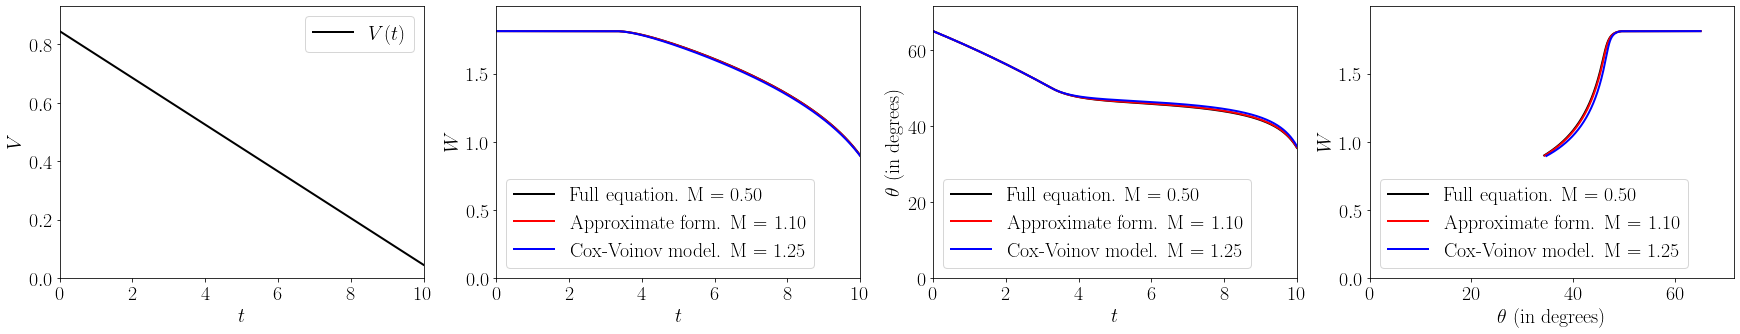

In [9]:
THETA0test = 65/180*np.pi # initial contact angle
w0 = 2*np.sin(THETA0test) # width of the spherical cap
V0 = (1/3)*np.pi*(2+np.cos(THETA0test))*(1-np.cos(THETA0test))**2
ThetaEQ = 50*np.pi/180 # equilibrium contact angle
h0, R0, theta0  = findTheta(V0, w0)
print("Error in initially assumed angle = %3.2e" % abs(theta0-THETA0test))

print("Initial drop characteristics: Vol = %3.2f, h = %3.2f, R = %3.2f, theta (degrees) = %3.2f, w = %3.2f\n" % (V0, h0, R0, theta0/np.pi*180, w0))

q = 0.08 # volume flow rate
t = np.linspace(0, 10, 10000) # time
DELTAt = t[1]-t[0]

V = V0 - q*t # volume of the spherical cap as a function of time

# model without Taylor expansion
M1 = 0.5
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M1)*(np.cos(theta)-np.cos(ThetaEQ))
    w.append(w[-1] + Force*DELTAt)

THETA = np.array(thetaTemp)    
W = np.array(w)

# model with Taylor expansion
M2 = 1.1
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M2)*(ThetaEQ**2-theta**2)
    w.append(w[-1] + Force*DELTAt)

THETA2 = np.array(thetaTemp)    
W2 = np.array(w)

# Cox-Voinov model
M3 = 1.25
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M3)*(ThetaEQ**3-theta**3)
    w.append(w[-1] + Force*DELTAt)

THETA3 = np.array(thetaTemp)    
W3 = np.array(w)


# now, we make some plots!
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

ax1.plot(t, V, 'k-', lw=2, label=r'$V(t)$')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$V$')
ax1.legend(loc='best', fontsize=TickLabel)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 1.1*V.max())

ax2.plot(t, W, 'k-', lw=2, label='Full equation. M = %3.2f' % M1)
ax2.plot(t, W2, 'r-', lw=2, label='Approximate form. M = %3.2f' % M2)
ax2.plot(t, W3, 'b-', lw=2, label='Cox-Voinov model. M = %3.2f' % M3)
ax2.set_xlabel('$t$')
ax2.set_ylabel('$W$')
ax2.legend(loc='best', fontsize=TickLabel)
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 1.1*W.max())

ax3.plot(t, THETA/np.pi*180, 'k-', lw=2, label='Full equation. M = %3.2f' % M1)
ax3.plot(t, THETA2/np.pi*180, 'r-', lw=2, label='Approximate form. M = %3.2f' % M2)
ax3.plot(t, THETA3/np.pi*180, 'b-', lw=2, label='Cox-Voinov model. M = %3.2f' % M3)
ax3.set_xlabel('$t$')
ax3.set_ylabel('$\\theta$ (in degrees)')
ax3.legend(loc='best', fontsize=TickLabel)
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 1.1*(THETA.max()/np.pi*180))

ax4.plot(THETA/np.pi*180, W, 'k-', lw=2, label='Full equation. M = %3.2f' % M1)
ax4.plot(THETA2/np.pi*180, W2, 'r-', lw=2, label='Approximate form. M = %3.2f' % M2)
ax4.plot(THETA3/np.pi*180, W3, 'b-', lw=2, label='Cox-Voinov model. M = %3.2f' % M3)
ax4.set_ylabel('$W$')
ax4.set_xlabel('$\\theta$ (in degrees)')
ax4.legend(loc='best', fontsize=TickLabel)
ax4.set_ylim(0, 1.1*W.max())
ax4.set_xlim(0, 1.1*(THETA.max()/np.pi*180))
plt.show()

# Comparision with Davis boundary condition


### Case 1 (Full equation):
$$ v = \frac{dw}{dt} =
	\begin{cases}
		\quad\,\,0 &\forall\quad\theta > \theta_{eq}\\
		\,\,\,-\frac{1}{M_1}\left(\cos\theta - \cos\theta_{eq}\right) &\forall\quad\theta < \theta_{eq}
	\end{cases}$$

### Case 2 (Approximate form):
$$ v = \frac{dw}{dt} =
	\begin{cases}
		\quad\,\,0 &\forall\quad\theta > \theta_{eq}\\
		\,\,\,-\frac{1}{M_2}\left(\theta_{eq}^2 - \theta^2\right) &\forall\quad\theta < \theta_{eq}
	\end{cases}$$

 ### Case 3 (Cox-Voinov model): 
 $$ v = \frac{dw}{dt} =
	\begin{cases}
		\quad\,\,0 &\forall\quad\theta > \theta_{eq}\\
		\,\,\,-\frac{1}{M_3}\left(\theta_{eq}^3 - \theta^3\right) &\forall\quad\theta < \theta_{eq}
	\end{cases}$$

 ### Case 4 (S. Davis model): 
 $$ v = \frac{dw}{dt} =
	\begin{cases}
		\quad\,\,0 &\forall\quad\theta > \theta_{eq}\\
		\,\,\,-\frac{1}{M_4}\left(\theta_{eq} - \theta\right) &\forall\quad\theta < \theta_{eq}
	\end{cases}$$

Error in initially assumed angle = 6.66e-16
Initial drop characteristics: Vol = 0.85, h = 0.58, R = 1.00, theta (degrees) = 65.00, w = 1.81



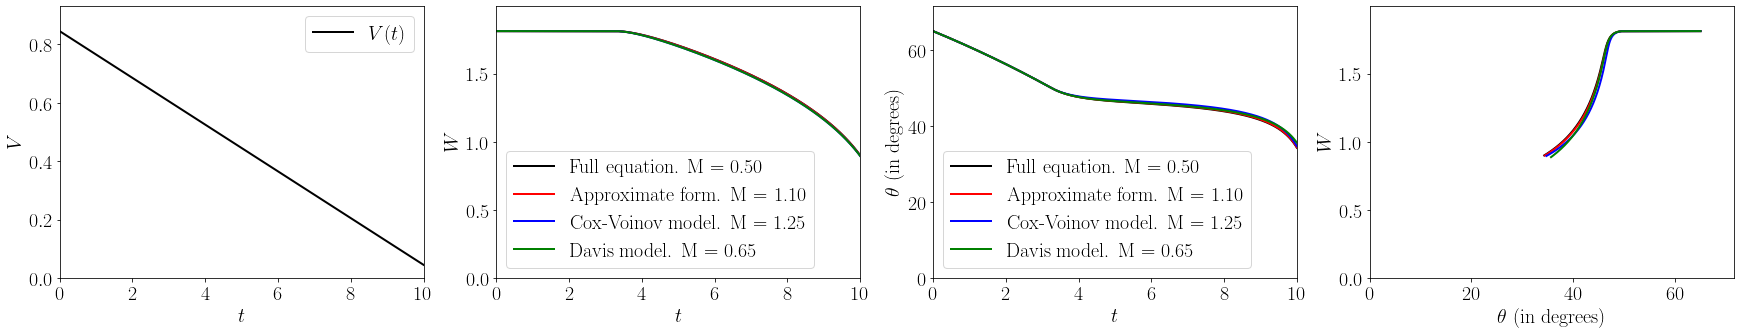

In [10]:
THETA0test = 65/180*np.pi # initial contact angle
w0 = 2*np.sin(THETA0test) # width of the spherical cap
V0 = (1/3)*np.pi*(2+np.cos(THETA0test))*(1-np.cos(THETA0test))**2
ThetaEQ = 50*np.pi/180 # equilibrium contact angle
h0, R0, theta0  = findTheta(V0, w0)
print("Error in initially assumed angle = %3.2e" % abs(theta0-THETA0test))

print("Initial drop characteristics: Vol = %3.2f, h = %3.2f, R = %3.2f, theta (degrees) = %3.2f, w = %3.2f\n" % (V0, h0, R0, theta0/np.pi*180, w0))

q = 0.08 # volume flow rate
t = np.linspace(0, 10, 10000) # time
DELTAt = t[1]-t[0]

V = V0 - q*t # volume of the spherical cap as a function of time

# model without Taylor expansion
M1 = 0.5
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M1)*(np.cos(theta)-np.cos(ThetaEQ))
    w.append(w[-1] + Force*DELTAt)

THETA = np.array(thetaTemp)    
W = np.array(w)

# model with Taylor expansion
M2 = 1.1
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M2)*(ThetaEQ**2-theta**2)
    w.append(w[-1] + Force*DELTAt)

THETA2 = np.array(thetaTemp)    
W2 = np.array(w)

# Cox-Voinov model
M3 = 1.25
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M3)*(ThetaEQ**3-theta**3)
    w.append(w[-1] + Force*DELTAt)

THETA3 = np.array(thetaTemp)    
W3 = np.array(w)

# Davis model
M4 = 0.65
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M4)*(ThetaEQ-theta)
    w.append(w[-1] + Force*DELTAt)

THETA4 = np.array(thetaTemp)    
W4 = np.array(w)


# now, we make some plots!
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

ax1.plot(t, V, 'k-', lw=2, label=r'$V(t)$')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$V$')
ax1.legend(loc='best', fontsize=TickLabel)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 1.1*V.max())

ax2.plot(t, W, 'k-', lw=2, label='Full equation. M = %3.2f' % M1)
ax2.plot(t, W2, 'r-', lw=2, label='Approximate form. M = %3.2f' % M2)
ax2.plot(t, W3, 'b-', lw=2, label='Cox-Voinov model. M = %3.2f' % M3)
ax2.plot(t, W3, 'g-', lw=2, label='Davis model. M = %3.2f' % M4)
ax2.set_xlabel('$t$')
ax2.set_ylabel('$W$')
ax2.legend(loc='best', fontsize=TickLabel)
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 1.1*W.max())

ax3.plot(t, THETA/np.pi*180, 'k-', lw=2, label='Full equation. M = %3.2f' % M1)
ax3.plot(t, THETA2/np.pi*180, 'r-', lw=2, label='Approximate form. M = %3.2f' % M2)
ax3.plot(t, THETA3/np.pi*180, 'b-', lw=2, label='Cox-Voinov model. M = %3.2f' % M3)
ax3.plot(t, THETA4/np.pi*180, 'g-', lw=2, label='Davis model. M = %3.2f' % M4)
ax3.set_xlabel('$t$')
ax3.set_ylabel('$\\theta$ (in degrees)')
ax3.legend(loc='best', fontsize=TickLabel)
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 1.1*(THETA.max()/np.pi*180))

ax4.plot(THETA/np.pi*180, W, 'k-', lw=2, label='Full equation. M = %3.2f' % M1)
ax4.plot(THETA2/np.pi*180, W2, 'r-', lw=2, label='Approximate form. M = %3.2f' % M2)
ax4.plot(THETA3/np.pi*180, W3, 'b-', lw=2, label='Cox-Voinov model. M = %3.2f' % M3)
ax4.plot(THETA4/np.pi*180, W4, 'g-', lw=2, label='Davis model. M = %3.2f' % M4)
ax4.set_ylabel('$W$')
ax4.set_xlabel('$\\theta$ (in degrees)')
# ax4.legend(loc='best', fontsize=TickLabel)
ax4.set_ylim(0, 1.1*W.max())
ax4.set_xlim(0, 1.1*(THETA.max()/np.pi*180))
plt.savefig("Comparision1.pdf", bbox_inches='tight')
plt.show()

Error in initially assumed angle = 2.22e-15
Initial drop characteristics: Vol = 1.82, h = 0.91, R = 1.00, theta (degrees) = 85.00, w = 1.99



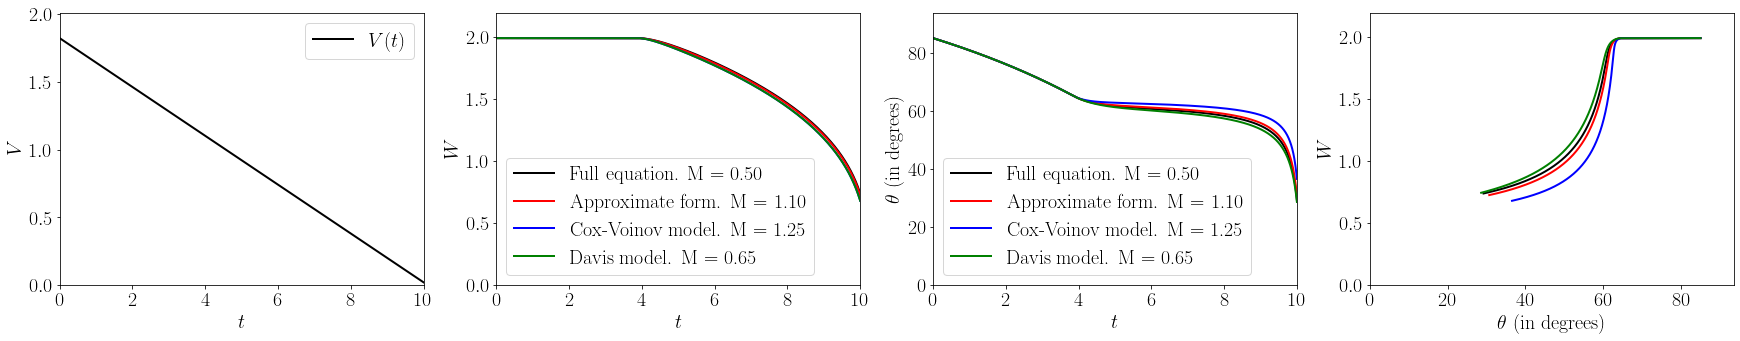

In [11]:
THETA0test = 85/180*np.pi # initial contact angle
w0 = 2*np.sin(THETA0test) # width of the spherical cap
V0 = (1/3)*np.pi*(2+np.cos(THETA0test))*(1-np.cos(THETA0test))**2
ThetaEQ = 65*np.pi/180 # equilibrium contact angle
h0, R0, theta0  = findTheta(V0, w0)
print("Error in initially assumed angle = %3.2e" % abs(theta0-THETA0test))

print("Initial drop characteristics: Vol = %3.2f, h = %3.2f, R = %3.2f, theta (degrees) = %3.2f, w = %3.2f\n" % (V0, h0, R0, theta0/np.pi*180, w0))

q = 0.18 # volume flow rate
t = np.linspace(0, 10, 10000) # time
DELTAt = t[1]-t[0]

V = V0 - q*t # volume of the spherical cap as a function of time

# model without Taylor expansion
M1 = 0.5
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M1)*(np.cos(theta)-np.cos(ThetaEQ))
    w.append(w[-1] + Force*DELTAt)

THETA = np.array(thetaTemp)    
W = np.array(w)

# model with Taylor expansion
M2 = 1.1
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M2)*(ThetaEQ**2-theta**2)
    w.append(w[-1] + Force*DELTAt)

THETA2 = np.array(thetaTemp)    
W2 = np.array(w)

# Cox-Voinov model
M3 = 1.25
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M3)*(ThetaEQ**3-theta**3)
    w.append(w[-1] + Force*DELTAt)

THETA3 = np.array(thetaTemp)    
W3 = np.array(w)

# Davis model
M4 = 0.65
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M4)*(ThetaEQ-theta)
    w.append(w[-1] + Force*DELTAt)

THETA4 = np.array(thetaTemp)    
W4 = np.array(w)


# now, we make some plots!
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

ax1.plot(t, V, 'k-', lw=2, label=r'$V(t)$')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$V$')
ax1.legend(loc='best', fontsize=TickLabel)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 1.1*V.max())

ax2.plot(t, W, 'k-', lw=2, label='Full equation. M = %3.2f' % M1)
ax2.plot(t, W2, 'r-', lw=2, label='Approximate form. M = %3.2f' % M2)
ax2.plot(t, W3, 'b-', lw=2, label='Cox-Voinov model. M = %3.2f' % M3)
ax2.plot(t, W3, 'g-', lw=2, label='Davis model. M = %3.2f' % M4)
ax2.set_xlabel('$t$')
ax2.set_ylabel('$W$')
ax2.legend(loc='best', fontsize=TickLabel)
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 1.1*W.max())

ax3.plot(t, THETA/np.pi*180, 'k-', lw=2, label='Full equation. M = %3.2f' % M1)
ax3.plot(t, THETA2/np.pi*180, 'r-', lw=2, label='Approximate form. M = %3.2f' % M2)
ax3.plot(t, THETA3/np.pi*180, 'b-', lw=2, label='Cox-Voinov model. M = %3.2f' % M3)
ax3.plot(t, THETA4/np.pi*180, 'g-', lw=2, label='Davis model. M = %3.2f' % M4)
ax3.set_xlabel('$t$')
ax3.set_ylabel('$\\theta$ (in degrees)')
ax3.legend(loc='best', fontsize=TickLabel)
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 1.1*(THETA.max()/np.pi*180))

ax4.plot(THETA/np.pi*180, W, 'k-', lw=2, label='Full equation. M = %3.2f' % M1)
ax4.plot(THETA2/np.pi*180, W2, 'r-', lw=2, label='Approximate form. M = %3.2f' % M2)
ax4.plot(THETA3/np.pi*180, W3, 'b-', lw=2, label='Cox-Voinov model. M = %3.2f' % M3)
ax4.plot(THETA4/np.pi*180, W4, 'g-', lw=2, label='Davis model. M = %3.2f' % M4)
ax4.set_ylabel('$W$')
ax4.set_xlabel('$\\theta$ (in degrees)')
# ax4.legend(loc='best', fontsize=TickLabel)
ax4.set_ylim(0, 1.1*W.max())
ax4.set_xlim(0, 1.1*(THETA.max()/np.pi*180))
plt.savefig("Comparision2.pdf", bbox_inches='tight')
plt.show()

Error in initially assumed angle = 2.22e-15
Initial drop characteristics: Vol = 1.82, h = 0.91, R = 1.00, theta (degrees) = 85.00, w = 1.99



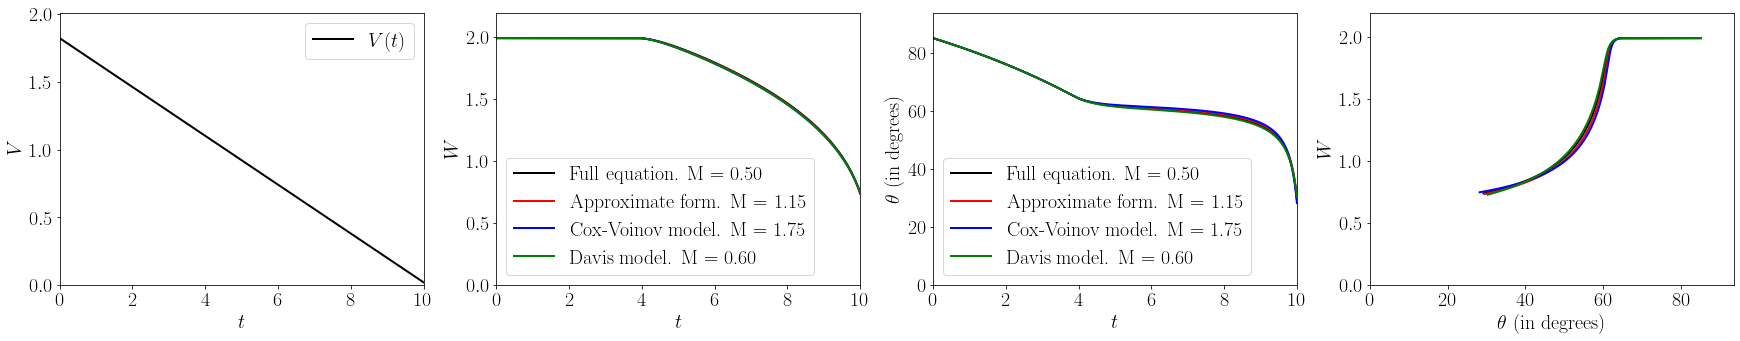

In [14]:
THETA0test = 85/180*np.pi # initial contact angle
w0 = 2*np.sin(THETA0test) # width of the spherical cap
V0 = (1/3)*np.pi*(2+np.cos(THETA0test))*(1-np.cos(THETA0test))**2
ThetaEQ = 65*np.pi/180 # equilibrium contact angle
h0, R0, theta0  = findTheta(V0, w0)
print("Error in initially assumed angle = %3.2e" % abs(theta0-THETA0test))

print("Initial drop characteristics: Vol = %3.2f, h = %3.2f, R = %3.2f, theta (degrees) = %3.2f, w = %3.2f\n" % (V0, h0, R0, theta0/np.pi*180, w0))

q = 0.18 # volume flow rate
t = np.linspace(0, 10, 10000) # time
DELTAt = t[1]-t[0]

V = V0 - q*t # volume of the spherical cap as a function of time

# model without Taylor expansion
M1 = 0.5
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M1)*(np.cos(theta)-np.cos(ThetaEQ))
    w.append(w[-1] + Force*DELTAt)

THETA = np.array(thetaTemp)    
W = np.array(w)

# model with Taylor expansion
M2 = 1.15
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M2)*(ThetaEQ**2-theta**2)
    w.append(w[-1] + Force*DELTAt)

THETA2 = np.array(thetaTemp)    
W2 = np.array(w)

# Cox-Voinov model
M3 = 1.75
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M3)*(ThetaEQ**3-theta**3)
    w.append(w[-1] + Force*DELTAt)

THETA3 = np.array(thetaTemp)    
W3 = np.array(w)

# Davis model
M4 = 0.6
w = []
w.append(w0)
thetaTemp = []
thetaTemp.append(theta0)

for vol in V[1:]: 
  h, r, theta = findTheta(vol, float(w[-1]))
  thetaTemp.append(theta)
  if theta > ThetaEQ:
    w.append(w[-1])
  else:
    Force = -(1.0/M4)*(ThetaEQ-theta)
    w.append(w[-1] + Force*DELTAt)

THETA4 = np.array(thetaTemp)    
W4 = np.array(w)


# now, we make some plots!
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

ax1.plot(t, V, 'k-', lw=2, label=r'$V(t)$')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$V$')
ax1.legend(loc='best', fontsize=TickLabel)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 1.1*V.max())

ax2.plot(t, W, 'k-', lw=2, label='Full equation. M = %3.2f' % M1)
ax2.plot(t, W2, 'r-', lw=2, label='Approximate form. M = %3.2f' % M2)
ax2.plot(t, W3, 'b-', lw=2, label='Cox-Voinov model. M = %3.2f' % M3)
ax2.plot(t, W3, 'g-', lw=2, label='Davis model. M = %3.2f' % M4)
ax2.set_xlabel('$t$')
ax2.set_ylabel('$W$')
ax2.legend(loc='best', fontsize=TickLabel)
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 1.1*W.max())

ax3.plot(t, THETA/np.pi*180, 'k-', lw=2, label='Full equation. M = %3.2f' % M1)
ax3.plot(t, THETA2/np.pi*180, 'r-', lw=2, label='Approximate form. M = %3.2f' % M2)
ax3.plot(t, THETA3/np.pi*180, 'b-', lw=2, label='Cox-Voinov model. M = %3.2f' % M3)
ax3.plot(t, THETA4/np.pi*180, 'g-', lw=2, label='Davis model. M = %3.2f' % M4)
ax3.set_xlabel('$t$')
ax3.set_ylabel('$\\theta$ (in degrees)')
ax3.legend(loc='best', fontsize=TickLabel)
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 1.1*(THETA.max()/np.pi*180))

ax4.plot(THETA/np.pi*180, W, 'k-', lw=2, label='Full equation. M = %3.2f' % M1)
ax4.plot(THETA2/np.pi*180, W2, 'r-', lw=2, label='Approximate form. M = %3.2f' % M2)
ax4.plot(THETA3/np.pi*180, W3, 'b-', lw=2, label='Cox-Voinov model. M = %3.2f' % M3)
ax4.plot(THETA4/np.pi*180, W4, 'g-', lw=2, label='Davis model. M = %3.2f' % M4)
ax4.set_ylabel('$W$')
ax4.set_xlabel('$\\theta$ (in degrees)')
# ax4.legend(loc='best', fontsize=TickLabel)
ax4.set_ylim(0, 1.1*W.max())
ax4.set_xlim(0, 1.1*(THETA.max()/np.pi*180))

plt.savefig("Comparision3.pdf", bbox_inches='tight')
plt.show()